In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1664)

In [2]:
def load_images(filename):
    with open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        assert magic_number == 2051 #images file
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        images = np.fromfile(f, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)
    return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        assert magic_number == 2049 #labels file

        _ = int.from_bytes(f.read(4), 'big')
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [3]:
train_images = load_images('./datasets/MNIST/train-images.idx3-ubyte')
train_labels = load_labels('./datasets/MNIST/train-labels.idx1-ubyte')
test_images = load_images('./datasets/MNIST/t10k-images.idx3-ubyte')
test_labels = load_labels('./datasets/MNIST/t10k-labels.idx1-ubyte')

print(f'Train images: {train_images.shape}')
print(f'Train labels: {train_labels.shape}')
print(f'Test images: {test_images.shape}')
print(f'Test images: {test_labels.shape}')

Train images: (60000, 28, 28)
Train labels: (60000,)
Test images: (10000, 28, 28)
Test images: (10000,)


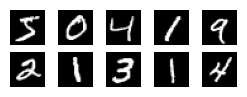

In [4]:
# Display first ten images of train set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(3, 1))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].axis('off')  # Hide axes

plt.show()

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 32)
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 10)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return self.l3(x) 

In [6]:
X = torch.from_numpy(train_images).float()
X = X.view(X.size(0), -1) # [60000, 28, 28] to [60000, 784]
Y = torch.from_numpy(train_labels)
dataset = TensorDataset(X, Y)

In [7]:
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    accuracy = 0
    for batch_X, batch_Y in data_loader:
        pred = model(batch_X)
        loss = loss_fn(pred, batch_Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        correct_pred = (torch.argmax(pred, dim=1) == batch_Y).float()
        accuracy += correct_pred.sum()        
    accuracy /= len(data_loader.dataset)
    print(f'Epoch {epoch} accuracy {accuracy:.3f}')

Epoch 0 accuracy 0.847
Epoch 1 accuracy 0.931
Epoch 2 accuracy 0.944
Epoch 3 accuracy 0.948
Epoch 4 accuracy 0.953
Epoch 5 accuracy 0.955
Epoch 6 accuracy 0.957
Epoch 7 accuracy 0.959
Epoch 8 accuracy 0.961
Epoch 9 accuracy 0.963
Epoch 10 accuracy 0.963
Epoch 11 accuracy 0.964
Epoch 12 accuracy 0.966
Epoch 13 accuracy 0.967
Epoch 14 accuracy 0.968
Epoch 15 accuracy 0.968
Epoch 16 accuracy 0.969
Epoch 17 accuracy 0.969
Epoch 18 accuracy 0.971
Epoch 19 accuracy 0.971


In [8]:
X_test = torch.from_numpy(test_images).float()
X_test = X_test.view(X_test.size(0), -1)
Y_test = torch.from_numpy(test_labels)

misclassified = []

correct = 0
with torch.no_grad():
    y_hat = model.forward(X_test)
    for i in range(0, len(X_test)):
        digit = torch.argmax(y_hat[i]).item()
        if Y_test[i].item() == digit:
            correct += 1
        else:
            misclassified.append((i, digit))
    print(correct / len(X_test))

0.9536


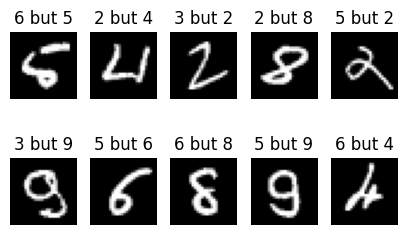

In [9]:
# Misclassified examples
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(5, 3))
axes = axes.ravel()

for i in range(10):
    idx, digit = misclassified[i]
    axes[i].imshow(test_images[idx], cmap='gray')
    axes[i].set_title(f'{digit} but {test_labels[idx]}') 
    axes[i].axis('off')  # Hide axes

plt.show()